In [1]:
import numpy as np
import matplotlib.pyplot as plt
from emnist import extract_training_samples, extract_test_samples
import tensorflow as tf
from tensorflow.keras import regularizers#type:ignore
from tensorflow.keras.models import Sequential#type:ignore
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,BatchNormalization,Dropout#type:ignore
from tensorflow.keras.utils import to_categorical#type:ignore
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator# type: ignore
import seaborn as sns
import pandas as pd
import cv2

In [2]:
train_images, train_labels = extract_training_samples('letters')
test_images, test_labels = extract_test_samples('letters')

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [4]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [5]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [6]:
print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")

Training data shape: (124800, 28, 28, 1)
Test data shape: (20800, 28, 28, 1)


In [7]:
datagen = ImageDataGenerator(
    rotation_range=9,
    width_shift_range=0.05,
    height_shift_range=0.05,
)

# Fit the generator to the data
datagen.fit(train_images)

In [8]:
test_datagen = ImageDataGenerator()
test_datagen.fit(test_images)

In [9]:
model = Sequential([
    tf.keras.Input(shape=(28,28,1)),
    Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.5),
    Dense(27, activation='softmax',kernel_regularizer=regularizers.l2(0.0001))  # 26 letters + 1 extra class for indexing
])

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath='bestloss.keras', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath='bestacc.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [12]:
model.fit(datagen.flow(train_images,train_labels,batch_size=97), epochs=12,
           validation_data=test_datagen.flow(test_images,test_labels, batch_size=97),
           callbacks=[checkpoint_callback1,checkpoint_callback2])

Epoch 1/12
   1/1287 ━━━━━━━━━━━━━━━━━━━━ 33:32 2s/step - accuracy: 0.0619 - loss: 5.8728

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1286/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6241 - loss: 1.3268
Epoch 1: val_loss improved from inf to 0.47263, saving model to bestloss.keras

Epoch 1: val_accuracy improved from -inf to 0.86543, saving model to bestacc.keras
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.6243 - loss: 1.3261 - val_accuracy: 0.8654 - val_loss: 0.4726
Epoch 2/12
1286/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8492 - loss: 0.5223
Epoch 2: val_loss improved from 0.47263 to 0.35365, saving model to bestloss.keras

Epoch 2: val_accuracy improved from 0.86543 to 0.90346, saving model to bestacc.keras
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.8493 - loss: 0.5222 - val_accuracy: 0.9035 - val_loss: 0.3537
Epoch 3/12
1285/1287 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8716 - loss: 0.4615
Epoch 3: val_loss improved from 0.35365 to 0.31103, saving model to bestloss.keras

Epoch 3: val_accuracy improved from 0.90346 to 0.92010, saving model to bestacc.keras

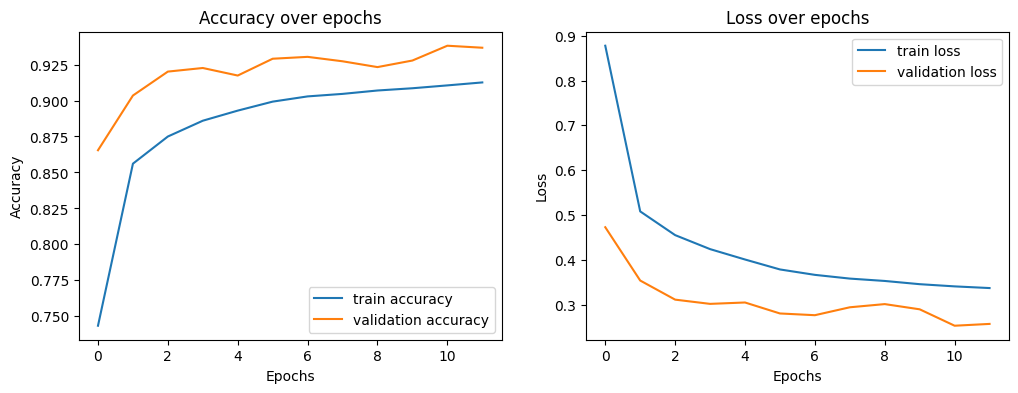

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], label='train accuracy')
plt.plot(model.history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [15]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy:}")

Test Accuracy: 0.9366826923076923


In [16]:
model.save("acc0933lo0273.keras")

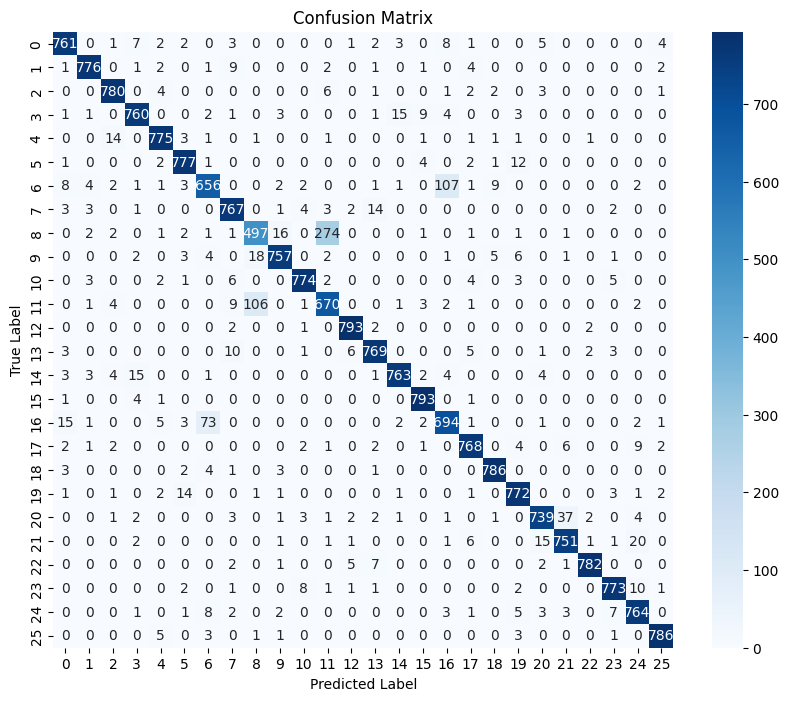

In [17]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt="g", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [18]:
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       800
           2       0.98      0.97      0.97       800
           3       0.96      0.97      0.97       800
           4       0.95      0.95      0.95       800
           5       0.97      0.97      0.97       800
           6       0.96      0.97      0.96       800
           7       0.87      0.82      0.84       800
           8       0.94      0.96      0.95       800
           9       0.80      0.62      0.70       800
          10       0.96      0.95      0.95       800
          11       0.97      0.97      0.97       800
          12       0.70      0.84      0.76       800
          13       0.98      0.99      0.98       800
          14       0.96      0.96      0.96       800
          15       0.97      0.95      0.96       800
          16       0.97      0.99      0.98       800
          17       0.84      0.87      0.85       800
    

In [19]:
def preprocess_image(img):
    """Preprocess the input image to the required format (28x28, grayscale)."""
    img = cv2.resize(img, (28, 28))  # Resize the image to 28x28 pixels
    img = img.astype('float32') / 255  # Normalize pixel values
    img = img.reshape(28, 28, 1)  # Reshape for model input (1 channel)
    return img

In [20]:
def segment_characters(word_image):
    """Segment the word image into individual character images."""
    # Convert to grayscale and apply binary threshold
    gray = cv2.cvtColor(word_image, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Apply dilation to separate characters more clearly
    kernel = np.ones((2, 2), np.uint8)
    dilated = cv2.dilate(binary_img, kernel, iterations=1)

    # Find contours in the image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours left-to-right (based on x-coordinate)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    char_images = []
    
    # Extract individual character images from contours
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        # Filter out noise or very small contours by setting a minimum size
        if w > 4 and h > 6:  # Adjust these values based on the character sizes
            char_img = binary_img[y:y+h, x:x+w]
            char_img = preprocess_image(char_img)  # Preprocess individual character
            char_images.append(char_img)
    
    return char_images


In [21]:
def predict_word(model, word_image):
    """Predicts the characters in a word image by segmenting the characters first."""
    char_images = segment_characters(word_image)
    predicted_chars = [np.argmax(model.predict(img.reshape(1, 28, 28, 1)), axis=-1)[0] for img in char_images]
    # Convert numerical predictions back to characters (1: 'A', 26: 'Z')
    return ''.join([chr(65 + pred - 1) for pred in predicted_chars])

In [22]:
#model = load_model('path_to_your_model.h5')

In [23]:
word_image = cv2.imread('a.jpg')

In [24]:
predicted_word = predict_word(model, word_image)
print("Predicted Word:", predicted_word)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Word: ARYAN


In [25]:
def predict_from_image(word_image):
    """Wrapper function to take an input image and return the predicted word."""
    predicted_word = predict_word(model, word_image)
    return predicted_word

In [ ]:
import gradio as gr
interface = gr.Interface(fn=predict_from_image, 
                         inputs=gr.Image(type="numpy", label="Upload an Image of a Word"), 
                         outputs=gr.Textbox(label="Predicted Word"))

# Launch the Gradio app
interface.launch()

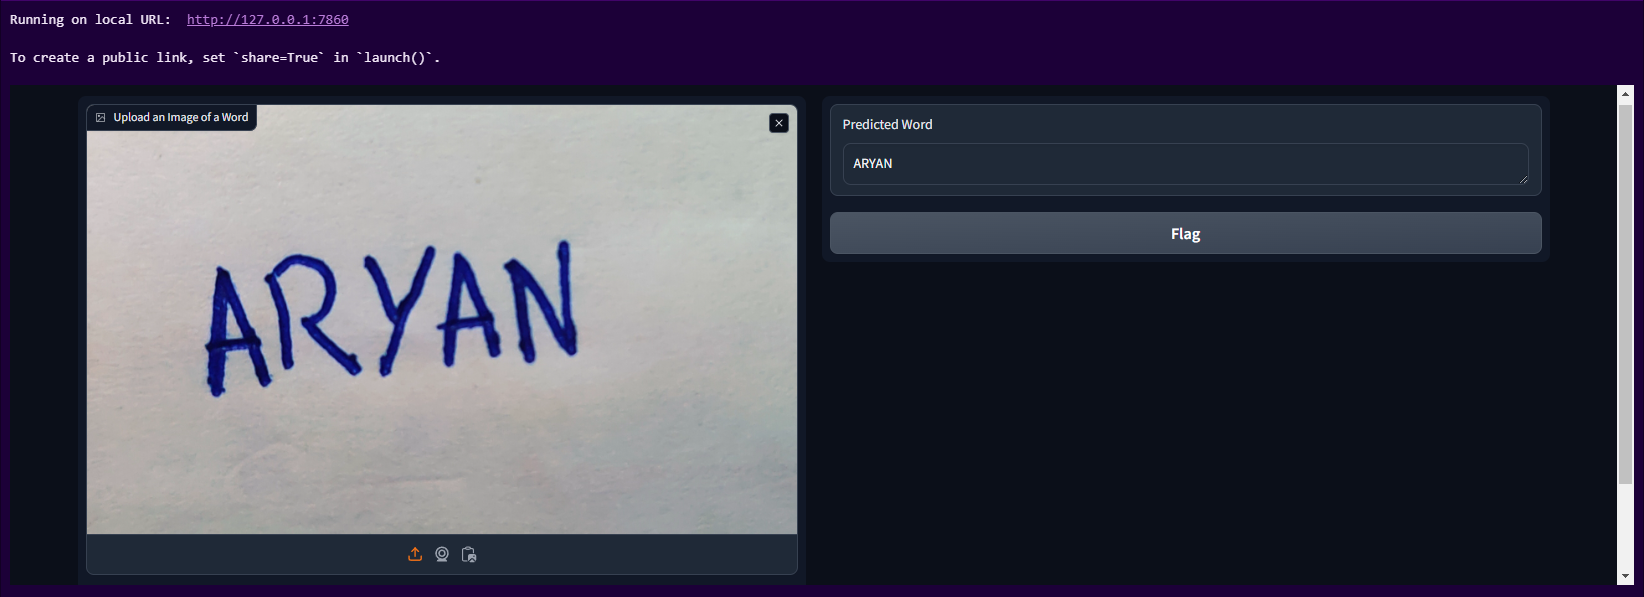